In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_datasets as tfds

In [3]:
(dataset_train_original, dataset_validate_original), info = tfds.load(
    "cats_vs_dogs",
    split=["train[:10%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='C:\\Users\\DAnand\\tensorflow_datasets\\cats_vs_dogs\\4.0.0',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) 

# Look at your beeping data

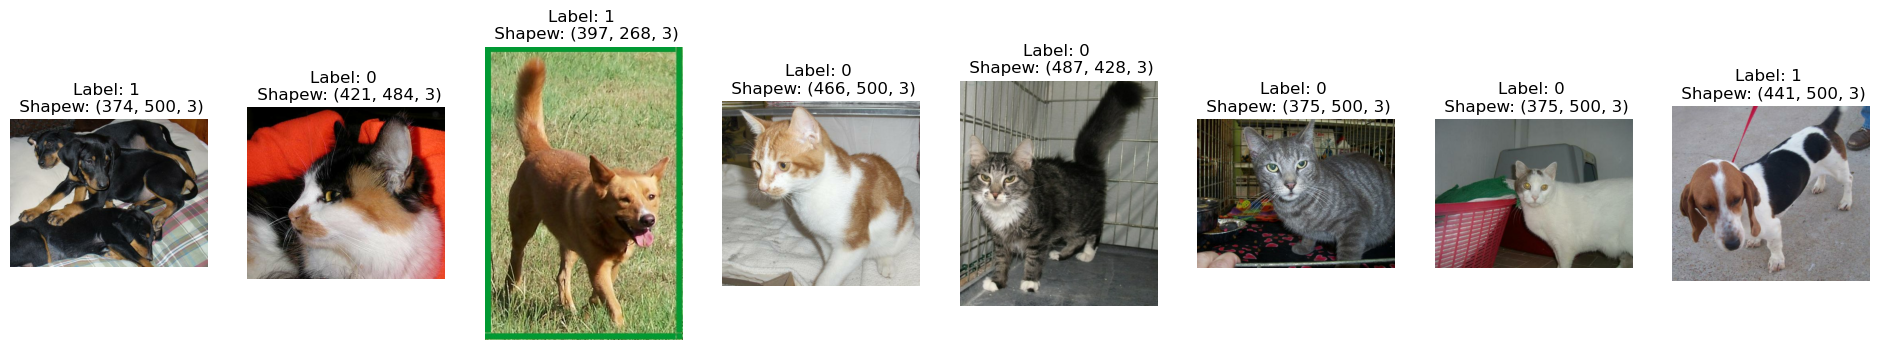

In [4]:
num_samples = 8
index = 1
plt.figure(figsize=(24,4))

for x,y in dataset_train_original.shuffle(100).take(num_samples):
    plt.subplot(1,num_samples, index)
    plt.imshow(x.numpy())
    plt.title(f"Label: {y.numpy()} \n Shapew: {x.numpy().shape}")
    plt.axis("off")
    index +=1

In [5]:
# dir(dataset_train_original)

# Data preprocessing

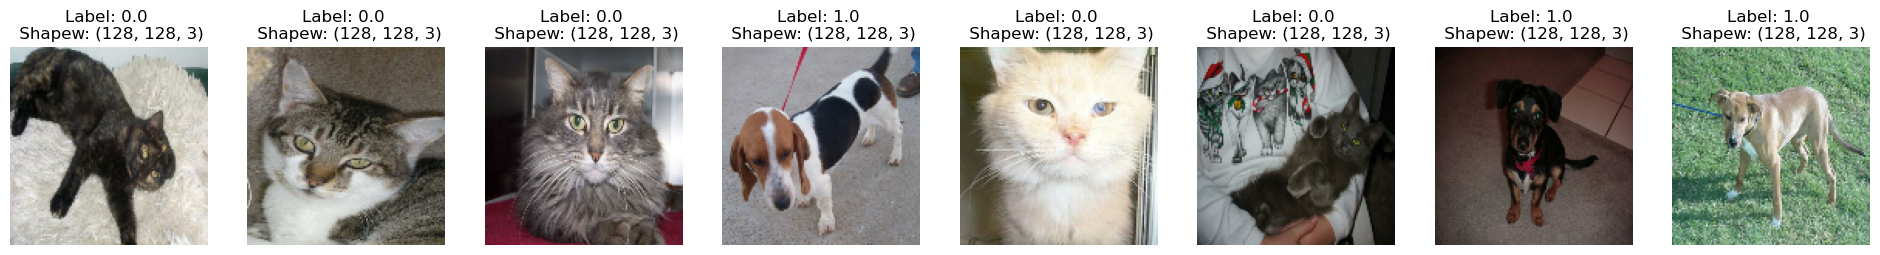

In [6]:
def encode(image, label, image_size=(128,128)):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, image_size)
    label = tf.cast(label, tf.float32)
    return image, label



dataset = dataset_train_original.map(lambda image, label: encode(image, label))

num_samples = 8
index = 1
plt.figure(figsize=(24,4))

for x,y in dataset.take(num_samples):
    plt.subplot(1,num_samples, index)
    plt.imshow(x.numpy())
    plt.title(f"Label: {y.numpy()} \n Shapew: {x.numpy().shape}")
    plt.axis("off")
    index +=1

In [7]:
dataset_train = dataset_train_original.map(lambda image, label: encode(image, label))
dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(2500)
dataset_train = dataset_train.batch(128)

dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label))
dataset_validate = dataset_validate.cache()
dataset_validate = dataset_validate.batch(128)


In [8]:
history_dict = {}
epochs = 50 

def render_history(history):
    plt.title("Losses")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.title("Accuracies")
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

def compare_histories():
    for training_names, history in history_dict.items():
        plt.plot(history["val_accuracy"], label=traing_name)
    plt.legend()
    plt.show()
    plt.close()

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(
    32,
    (3,3),
    padding="same",
    activation="relu",
    input_shape=(128,128,3)
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(
    32,
    (3,3),
    padding="same",
    activation="relu",
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(
    64,
    (3,3),
    padding="same",
    activation="relu",
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(
    64,
    (3,3),
    padding="same",
    activation="relu",
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    validation_data=dataset_validate,
    epochs=epochs
)

history_dict["baseline"] = history.history
render_history(history)
compare_histories()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

KeyboardInterrupt: 

In [ ]:
# model = models.Sequential()
# model.add(layers.Conv2D(
#     8,
#     (3,3),
#     activation="relu",
#     input_shape=(32,32,3)
# ))
# model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Conv2D(
#     16,
#     (3,3),
#     activation="relu"
# ))
# model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Conv2D(
#     32,
#     (3,3),
#     activation="relu"
# ))
# model.add(layers.Flatten())
# model.add(layers.Dense(10, activation="softmax"))

# model.summary()

# model.compile(
#     optimizer="adam",
#     loss="sparse_categorical_crossentropy",
#     metrics=["accuracy"]
# )

# history = model.fit(
#     dataset_train,
#     validation_data=dataset_validate,
#     epochs=50
# )

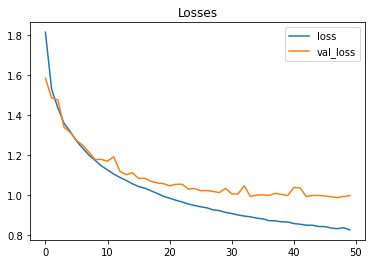

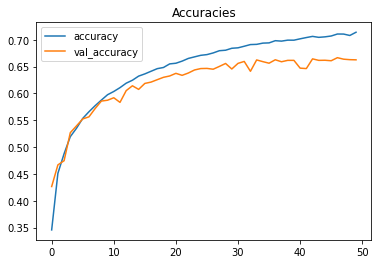

In [ ]:
render_history(history)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(
    16,
    (3,3),
    activation="relu",
    input_shape=(32,32,3)
))
# model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(
    32,
    (3,3),
    activation="relu"
))
model.add(layers.Conv2D(
    64,
    (3,3),
    activation="relu"
))
model.add(layers.Conv2D(
    64,
    (3,3),
    activation="relu"
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(
    64,
    (3,3),
    activation="relu"
))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation="softmax"))

model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 conv2d_35 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 conv2d_36 (Conv2D)          (None, 26, 26, 64)        18496     
                                                                 
 conv2d_37 (Conv2D)          (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 10, 10, 64)        36928     
                                                     

In [ ]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    validation_data=dataset_validate,
    epochs=50
)

Epoch 1/50
391/391 [==============================] - 9s 20ms/step - loss: 1.6204 - accuracy: 0.4119 - val_loss: 1.3851 - val_accuracy: 0.5024
Epoch 2/50
391/391 [==============================] - 7s 17ms/step - loss: 1.2467 - accuracy: 0.5570 - val_loss: 1.1435 - val_accuracy: 0.5927
Epoch 3/50
391/391 [==============================] - 7s 17ms/step - loss: 1.0554 - accuracy: 0.6286 - val_loss: 1.0514 - val_accuracy: 0.6322
Epoch 4/50
391/391 [==============================] - 7s 17ms/step - loss: 0.9278 - accuracy: 0.6781 - val_loss: 0.9688 - val_accuracy: 0.6628
Epoch 5/50
391/391 [==============================] - 7s 17ms/step - loss: 0.8295 - accuracy: 0.7122 - val_loss: 0.9308 - val_accuracy: 0.6740
Epoch 6/50
391/391 [==============================] - 6s 16ms/step - loss: 0.7547 - accuracy: 0.7374 - val_loss: 0.8635 - val_accuracy: 0.6973
Epoch 7/50
391/391 [==============================] - 7s 17ms/step - loss: 0.6953 - accuracy: 0.7595 - val_loss: 0.8585 - val_accuracy: 0.7048

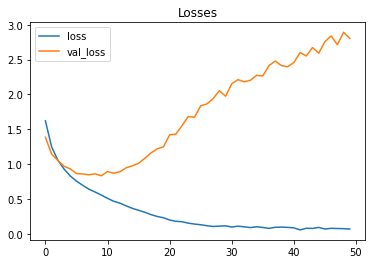

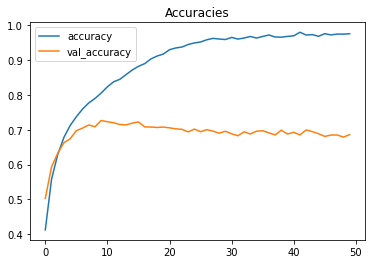

In [ ]:
render_history(history)

In [ ]:

model = models.Sequential()
model.add(layers.Conv2D(
    16,
    (3,3),
    activation="relu",
    input_shape=(32,32,3)
))
# model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(
    32,
    (3,3),
    activation="relu"
))
model.add(layers.Conv2D(
    64,
    (3,3),
    activation="relu"
))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(
    64,
    (3,3),
    activation="relu"
))
model.add(layers.Conv2D(
    32,
    (3,3),
    activation="relu"
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(
    32,
    (3,3),
    activation="relu"
))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation="softmax"))

model.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 conv2d_40 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 conv2d_41 (Conv2D)          (None, 26, 26, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 26, 26, 64)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 24, 24, 64)        36928     
                                                                 
 conv2d_43 (Conv2D)          (None, 22, 22, 32)        18464     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 11, 11, 32)     

In [ ]:

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    validation_data=dataset_validate,
    epochs=50
)

Epoch 1/50
391/391 [==============================] - 11s 21ms/step - loss: 1.6466 - accuracy: 0.3978 - val_loss: 1.3860 - val_accuracy: 0.4962
Epoch 2/50
391/391 [==============================] - 8s 21ms/step - loss: 1.3183 - accuracy: 0.5303 - val_loss: 1.1996 - val_accuracy: 0.5725
Epoch 3/50
391/391 [==============================] - 8s 21ms/step - loss: 1.1511 - accuracy: 0.5942 - val_loss: 1.0897 - val_accuracy: 0.6156
Epoch 4/50
391/391 [==============================] - 8s 21ms/step - loss: 1.0314 - accuracy: 0.6413 - val_loss: 1.0254 - val_accuracy: 0.6431
Epoch 5/50
391/391 [==============================] - 8s 20ms/step - loss: 0.9513 - accuracy: 0.6680 - val_loss: 0.9965 - val_accuracy: 0.6623
Epoch 6/50
391/391 [==============================] - 8s 20ms/step - loss: 0.8877 - accuracy: 0.6904 - val_loss: 0.9299 - val_accuracy: 0.6778
Epoch 7/50
391/391 [==============================] - 8s 20ms/step - loss: 0.8316 - accuracy: 0.7097 - val_loss: 0.9099 - val_accuracy: 0.681

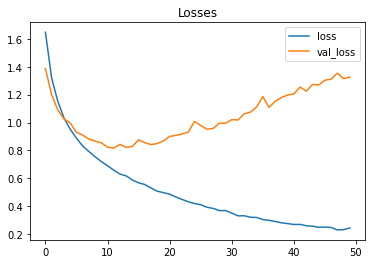

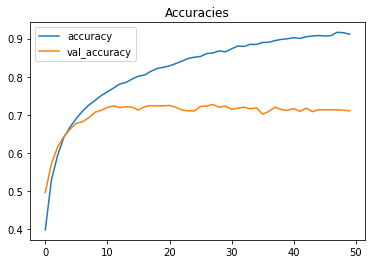

In [ ]:
render_history(history)

In [ ]:
model = models.Sequential()
# model.add(layers.Conv2D(
#     8,
#     (3,3),
#     activation="relu",
#     input_shape=(32,32,3)
# ))
model.add(layers.Conv2D(
    16,
    (3,3),
    activation="relu",
    input_shape=(32,32,3)
))
# model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(
    32,
    (3,3),
    activation="relu"
))
model.add(layers.Conv2D(
    64,
    (3,3),
    activation="relu"
))
model.add(layers.Conv2D(
    128,
    (3,3),
    activation="relu"
))
# model.add(layers.Dropout(0.2))
# model.add(layers.Conv2D(
#     128,
#     (3,3),
#     activation="relu"
# ))
# model.add(layers.Conv2D(
#     64,
#     (3,3),
#     activation="relu"
# ))
# model.add(layers.Dropout(0.2))
# model.add(layers.Conv2D(
#     64,
#     (3,3),
#     activation="relu"
# ))
# model.add(layers.Dropout(0.3))
# model.add(layers.Conv2D(
#     64,
#     (3,3),
#     activation="relu"
# ))
# model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(
    64,
    (3,3),
    activation="relu"
))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(
    64,
    (3,3),
    activation="relu"
))
model.add(layers.Conv2D(
    32,
    (3,3),
    activation="relu"
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(
    32,
    (3,3),
    activation="relu"
))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation="softmax"))
# model.build()
model.summary()


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_130 (Conv2D)         (None, 30, 30, 16)        448       
                                                                 
 conv2d_131 (Conv2D)         (None, 28, 28, 32)        4640      
                                                                 
 conv2d_132 (Conv2D)         (None, 26, 26, 64)        18496     
                                                                 
 conv2d_133 (Conv2D)         (None, 24, 24, 128)       73856     
                                                                 
 conv2d_134 (Conv2D)         (None, 22, 22, 64)        73792     
                                                                 
 dropout_29 (Dropout)        (None, 22, 22, 64)        0         
                                                                 
 conv2d_135 (Conv2D)         (None, 20, 20, 64)      

In [ ]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    validation_data=dataset_validate,
    epochs=50
)

Epoch 1/50
391/391 [==============================] - 14s 33ms/step - loss: 1.7344 - accuracy: 0.3615 - val_loss: 1.4790 - val_accuracy: 0.4535
Epoch 2/50
391/391 [==============================] - 13s 32ms/step - loss: 1.3676 - accuracy: 0.5061 - val_loss: 1.2926 - val_accuracy: 0.5293
Epoch 3/50
391/391 [==============================] - 13s 32ms/step - loss: 1.1982 - accuracy: 0.5728 - val_loss: 1.2127 - val_accuracy: 0.5706
Epoch 4/50
391/391 [==============================] - 13s 32ms/step - loss: 1.0825 - accuracy: 0.6157 - val_loss: 1.0802 - val_accuracy: 0.6114
Epoch 5/50
391/391 [==============================] - 12s 32ms/step - loss: 1.0007 - accuracy: 0.6420 - val_loss: 1.0144 - val_accuracy: 0.6372
Epoch 6/50
391/391 [==============================] - 12s 32ms/step - loss: 0.9326 - accuracy: 0.6699 - val_loss: 1.0840 - val_accuracy: 0.6080
Epoch 7/50
391/391 [==============================] - 13s 32ms/step - loss: 0.8861 - accuracy: 0.6860 - val_loss: 0.9093 - val_accuracy:

KeyboardInterrupt: ignored

In [ ]:
model = models.Sequential()
# model.add(layers.Conv2D(
#     8,
#     (3,3),
#     activation="relu",
#     input_shape=(32,32,3)
# ))
model.add(layers.Conv2D(
    16,
    (3,3),
    activation="relu",
    input_shape=(32,32,3),
    padding="same"
))
# model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(
    32,
    (3,3),
    activation="relu",
    padding="same"
))
model.add(layers.Conv2D(
    64,
    (3,3),
    activation="relu",
    padding="same"
))
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(
    128,
    (3,3),
    activation="relu",
    padding="same"
))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(
    128,
    (3,3),
    activation="relu",
    padding="same"
))
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(
    64,
    (3,3),
    activation="relu",
    padding="same"
))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(
    64,
    (3,3),
    activation="relu"
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(
    32,
    (3,3),
    activation="relu",
    padding="same"
))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(
    32,
    (3,3),
    activation="relu"
))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation="softmax"))
# model.build()
model.summary()


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_138 (Conv2D)         (None, 32, 32, 16)        448       
                                                                 
 conv2d_139 (Conv2D)         (None, 32, 32, 32)        4640      
                                                                 
 conv2d_140 (Conv2D)         (None, 32, 32, 64)        18496     
                                                                 
 dropout_30 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_141 (Conv2D)         (None, 32, 32, 128)       73856     
                                                                 
 dropout_31 (Dropout)        (None, 32, 32, 128)       0         
                                                                 
 conv2d_142 (Conv2D)         (None, 32, 32, 128)     

In [ ]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    validation_data=dataset_validate,
    epochs=50
)

Epoch 1/50
391/391 [==============================] - 57s 77ms/step - loss: 1.6995 - accuracy: 0.3782 - val_loss: 1.3749 - val_accuracy: 0.5052
Epoch 2/50
391/391 [==============================] - 29s 74ms/step - loss: 1.2910 - accuracy: 0.5330 - val_loss: 1.1815 - val_accuracy: 0.5754
Epoch 3/50
391/391 [==============================] - 29s 74ms/step - loss: 1.1314 - accuracy: 0.5976 - val_loss: 1.1116 - val_accuracy: 0.5994
Epoch 4/50
192/391 [=============>................] - ETA: 13s - loss: 1.0153 - accuracy: 0.6398